In [1]:
import numpy as np
import neurokit2 as nk
from scipy import integrate
import pickle

# compute acceleration
def acc(speed, time):
    return np.gradient(speed, time, edge_order=2)

# compute motion sickness dose value
def msdv_eq(speed, time):
    return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))

# find peaks
def find_peaks(gsr):
    decomposed_eda = nk.eda_process(gsr, sampling_rate=4)[0]
    eda_interval = nk.eda_intervalrelated(decomposed_eda, sampling_rate=4)
    num_of_peaks = eda_interval["SCR_Peaks_N"]
    return sum(num_of_peaks)

# load data
data_path = './data/raw_data2020.p'
dataPoolfont_sizefont_size = pickle.load(open(data_path, "rb"))

num_of_samples = len(list(dataPoolfont_sizefont_size.keys()))

# set interval number
num_of_interval = 30

input_list = []
output_list = []

# extract name, time, speed, GSR
for j in range(num_of_samples):
    name = list(dataPoolfont_sizefont_size.keys())[j]
    one_sample = dataPoolfont_sizefont_size[name]
    time_speed = one_sample.Steam.rawSpeed.Time
    raw_speed = one_sample.Steam.rawSpeed.Speed
    GSR = one_sample.Empatica.GSR
    time_eda = one_sample.Empatica.GSR.Time
    one_sample_input = []
    one_sample_output = []
    
    # adjust time scale
    t = np.arange(0, 0.25*len(GSR), 0.25)
    t_difference = t[-1] - time_speed.iloc[-1]
    if t_difference >= 0:
        countTimeInZero = int(t_difference/0.25)
        timeBase = t[countTimeInZero]
        t -= timeBase
    GSR.E4_Time = t
    GSR = GSR.drop(GSR[GSR.E4_Time < 0].index)
    GSR.reset_index(drop=True, inplace=True)
    
    # Peaks
    decomposed_eda = nk.eda_process(GSR.GSR, sampling_rate=4, method="neurokit")[0] # method="neurokit"
    step = int(len(GSR.GSR) / num_of_interval)
    peaks_list = []
    piece_gsr = []
    for i in range(0, len(GSR.GSR), step):
        if len(GSR.GSR[i: i+step]) < step:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i-step:], 
                                                  sampling_rate=4)
            peaks_list[-1] = eda_interval["SCR_Peaks_N"].values
            piece_gsr[-1] = decomposed_eda["EDA_Raw"][i-step:].values
        else:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i: i+step], 
                                                  sampling_rate=4)
            peaks_list.append(eda_interval["SCR_Peaks_N"].values)
            piece_gsr.append(decomposed_eda["EDA_Raw"][i: i+step].values)

    # MSDV
    msdv_list = []
    step = int(len(time_speed) / num_of_interval)
    speed_list = []
    for i in range(0, len(raw_speed), step):
        if len(raw_speed[i: i+step]) < step:
            speed_list[-1] = raw_speed[i-step:].values
            msdv_list[-1] = msdv_eq(raw_speed[i-step:], time_speed[i-step:])
        else:
            speed_list.append(raw_speed[i: i+step].values)
            msdv_list.append(msdv_eq(raw_speed[i: i+step], time_speed[i: i+step]))
    
    input_list.append([name, speed_list, piece_gsr]) # INPUT
    output_list.append([name, msdv_list, peaks_list]) # OUTPUT

# store final input and output lists (merged data)
merged_input_list = []
merged_output_list = []
for i in range(num_of_samples):
    # remove group name
    input_list[i][0] = input_list[i][0].split("group")[0]
    input_list[i][0] = input_list[i][0].split("gift")[0]
    output_list[i][0] = output_list[i][0].split("group")[0]
    output_list[i][0] = output_list[i][0].split("gift")[0]
# merge info based on the sequence of tests
skip_step, pivot = 0, 0
for i in range(num_of_samples):
    name = input_list[pivot][0]
    tmp_speed = input_list[pivot][1]
    tmp_gsr = input_list[pivot][2]
    tmp_msdv = output_list[pivot][1]
    tmp_peaks = output_list[pivot][2]
    matched = False
    for j in range(pivot+1, num_of_samples, 1):
        if name == input_list[j][0]:
            tmp_speed = tmp_speed + input_list[j][1]
            tmp_gsr = tmp_gsr + input_list[j][2]
            tmp_msdv = tmp_msdv + output_list[j][1]
            tmp_peaks = tmp_peaks + output_list[j][2]
            skip_step = j
            matched = True
    merged_input_list.append([name, tmp_speed, tmp_gsr])
    merged_output_list.append([name, tmp_msdv, tmp_peaks])
    if matched:
        pivot = skip_step+1
    else:
        pivot += 1
    if pivot >= num_of_samples:
        break


/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_intervalrelated.py:116: RuntimeWarning: Mean of empty slice
  output["SCR_Peaks_Amplitude_Mean"] = np.nanmean(data[peaks_idx]["SCR_Amplitude"].values)
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_41222/1768071292.py:12: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_41222/1768071292.py:12: De

/Users/davidzhan/anaconda3/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA s

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_input = pd.DataFrame(merged_input_list,columns=['tester', 'Speed', 'GSR'])
df_input

,tester,Speed,GSR
0,Andreas,"[[0.0, 1.408541, 1.405054, 1.40149, 1.399373, ...","[[2.327969, 2.362554, 2.41123, 2.466311, 2.527..."
1,Anjela,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.286659, 1.295627, 1.296908, 1.295627, 1.30..."
2,Anne,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.4264778, 0.4290392, 0.4277585, 0.4277585, ..."
3,Aron,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.2536119, 0.2536119, 0.2548928, 0.252331, 0..."
4,BingHan,"[[0.0, 0.4219726, 0.4100565, 0.4061294, 0.4035...","[[4.417199, 4.447938, 4.492765, 4.518382, 4.52..."
5,Bowen,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.1191279, 0.1178469, 0.1204088, 0.1191279, ..."
6,Chenyang,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.803594, 5.783101, 5.820244, 5.859949, 5.91..."
7,Cunbo,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.3537439, 0.3511825, 0.3499017, 0.3499017, ..."
8,Danfo,"[[0.0, 0.8736041, 0.8729813, 0.8732041, 0.8738...","[[0.3691569, 0.3627525, 0.3653143, 0.3307308, ..."
9,Emilio,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.2267, 0.2279808, 0.2279808, 0.2254192, 0.2..."


In [28]:
for i in df_input['tester']:
    print(i+'.png')

Andreas.png
Anjela.png
Anne.png
Aron.png
BingHan.png
Bowen.png
Chenyang.png
Cunbo.png
Danfo.png
Emilio.png
Fangnian.png
FelixLonge.png
Guanzhi.png
Haoming.png
Haoyang.png
Hongmin.png
HuanQin.png
JiaYu.png
Jieyang.png
Jingsi.png
Jingting.png
Johanna.png
Juliette.png
Junming.png
KeCao.png
Lea.png
Lingfeng.png
LiuWan.png
Lukas.png
Meihang.png
Mila.png
Minghui.png
Olaf.png
Qiansi.png
Qichen.png
Ramon.png
Shaoxiang.png
Theo.png
Tianci.png
Wenjun.png
Wenzhe.png
Xianfeng.png
XinZhu.png
Xinrui.png
YanZu.png
YiLuo.png
Yibo.png
Yiwei.png
Yuemiao.png
Yujia.png
Zheli.png
Zhilong.png
Zihan.png
Zunchao.png


Most participants took part in three sessions, with a small number participating in four sessions. Each session lasted four minutes, and the data collected during these four minutes was divided into 30 segments. Therefore, the total of 90 segments for each participant indicates that they completed three sessions, with all segments combined.

In [4]:
len(df_input['Speed'][0])

90

In [5]:
len(df_input['Speed'][0][0])

647

In [6]:
len(df_input['GSR'][0])

90

In [7]:
len(df_input['GSR'][0][0])

32

In [8]:
def calculate_statistics(data):
    statistics = {
        'mean': np.mean(data),
        'std': np.std(data),
        'max': np.max(data),
        'min': np.min(data)
    }
    return statistics

summary_stats = []
for i, row in df_input.iterrows():
    all_speeds = np.concatenate([np.array(x) for x in row['Speed']])
    all_gsr = np.concatenate([np.array(x) for x in row['GSR']])
    
    speed_stats = calculate_statistics(all_speeds)
    gsr_stats = calculate_statistics(all_gsr)
    
    summary_stats.append({
        'tester': row['tester'],
        'speed_mean': speed_stats['mean'],
        'speed_std': speed_stats['std'],
        'speed_max': speed_stats['max'],
        'speed_min': speed_stats['min'],
        'gsr_mean': gsr_stats['mean'],
        'gsr_std': gsr_stats['std'],
        'gsr_max': gsr_stats['max'],
        'gsr_min': gsr_stats['min']
    })

summary_df = pd.DataFrame(summary_stats)

print(summary_df)

        tester  speed_mean  speed_std  speed_max  speed_min   gsr_mean  \
0      Andreas    1.596836   0.576088   2.757172  -0.739268   5.052332   
1       Anjela    2.068480   0.592518   2.994416   0.000000   0.519321   
2         Anne    2.356649   0.453211   2.786855  -1.643699   0.428512   
3         Aron    1.860225   0.415734   2.612798  -0.259536   0.209462   
4      BingHan    1.701299   0.604137   2.911953  -0.816354   8.031133   
5        Bowen    1.272268   0.566786   2.261719  -1.484879   0.162240   
6     Chenyang    1.634757   0.712066   2.983379  -1.578933   4.886135   
7        Cunbo    1.680393   1.051425   3.499252  -2.999806   2.469378   
8        Danfo    1.830995   0.742174   2.988950  -1.483105   0.312223   
9       Emilio    1.888740   0.454301   2.865923   0.000000   0.162733   
10    Fangnian    2.363486   0.567024   2.893095  -0.655117   6.292756   
11  FelixLonge    1.305375   0.199566   1.493164   0.000000   3.571120   
12     Guanzhi    1.509614   0.738375 

In [9]:
# from statsmodels.tsa.stattools import adfuller, acf, pacf

# def time_series_analysis(data):
#     rolling_mean = pd.Series(data).rolling(window=5).mean()
    
#     diff_data = np.diff(data)
    
#     adf_result = adfuller(data)
#     adf_statistic = adf_result[0]
#     p_value = adf_result[1]
    
#     autocorr = acf(data)
#     pacf_vals = pacf(data)
    
#     features = {
#         'mean': np.mean(data),
#         'std': np.std(data),
#         'max': np.max(data),
#         'min': np.min(data),
#         'rolling_mean_last': rolling_mean.iloc[-1] if len(rolling_mean) > 0 else np.nan,
#         'diff_mean': np.mean(diff_data),
#         'diff_std': np.std(diff_data),
#         'adf_statistic': adf_statistic,
#         'p_value': p_value,
#         'first_autocorr': autocorr[1] if len(autocorr) > 1 else np.nan,
#         'first_pacf': pacf_vals[1] if len(pacf_vals) > 1 else np.nan
#     }
#     return features

# time_series_stats = []
# for i, row in df_input.iterrows():
#     # 将嵌套列表展平成一个数组
#     all_speeds = np.concatenate([np.array(x) for x in row['Speed']])
#     all_gsr = np.concatenate([np.array(x) for x in row['GSR']])
    
#     # 计算时间序列特征
#     speed_features = time_series_analysis(all_speeds)
#     gsr_features = time_series_analysis(all_gsr)
    
#     time_series_stats.append({
#         'tester': row['tester'],
#         'speed_mean': speed_features['mean'],
#         'speed_std': speed_features['std'],
#         'speed_max': speed_features['max'],
#         'speed_min': speed_features['min'],
#         'speed_rolling_mean_last': speed_features['rolling_mean_last'],
#         'speed_diff_mean': speed_features['diff_mean'],
#         'speed_diff_std': speed_features['diff_std'],
#         'speed_adf_statistic': speed_features['adf_statistic'],
#         'speed_p_value': speed_features['p_value'],
#         'speed_first_autocorr': speed_features['first_autocorr'],
#         'speed_first_pacf': speed_features['first_pacf'],
#         'gsr_mean': gsr_features['mean'],
#         'gsr_std': gsr_features['std'],
#         'gsr_max': gsr_features['max'],
#         'gsr_min': gsr_features['min'],
#         'gsr_rolling_mean_last': gsr_features['rolling_mean_last'],
#         'gsr_diff_mean': gsr_features['diff_mean'],
#         'gsr_diff_std': gsr_features['diff_std'],
#         'gsr_adf_statistic': gsr_features['adf_statistic'],
#         'gsr_p_value': gsr_features['p_value'],
#         'gsr_first_autocorr': gsr_features['first_autocorr'],
#         'gsr_first_pacf': gsr_features['first_pacf']
#     })

# time_series_df = pd.DataFrame(time_series_stats)

# print(time_series_df)

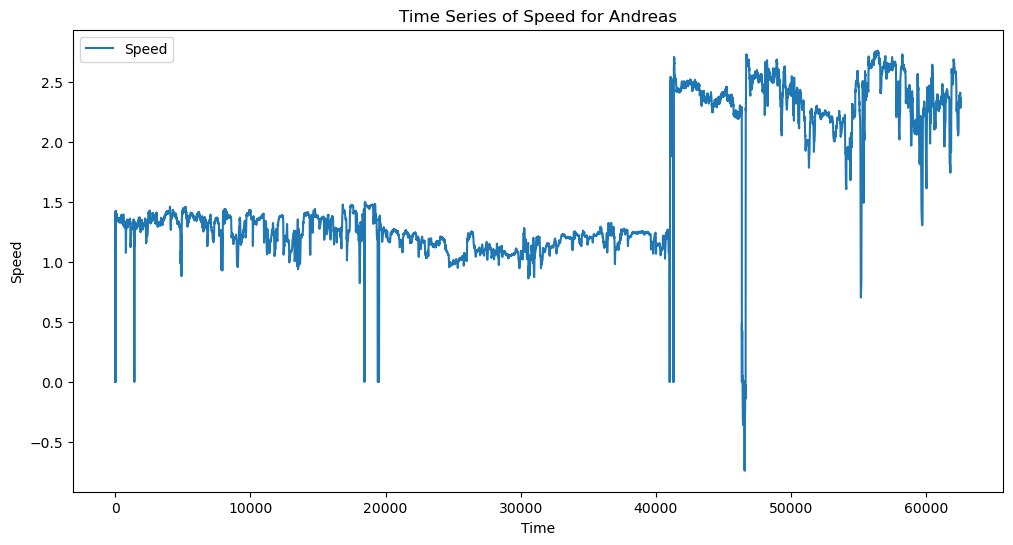

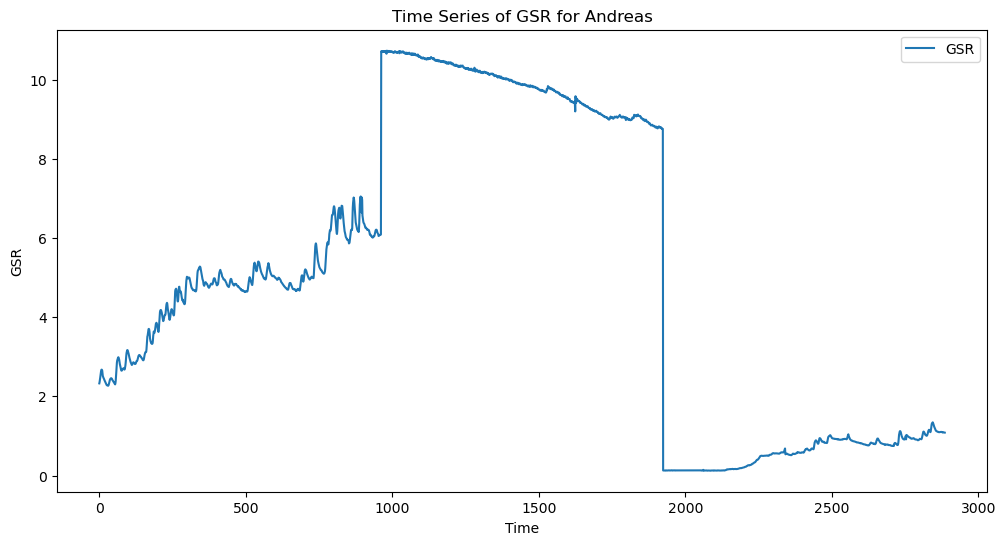

<Figure size 1200x600 with 0 Axes>

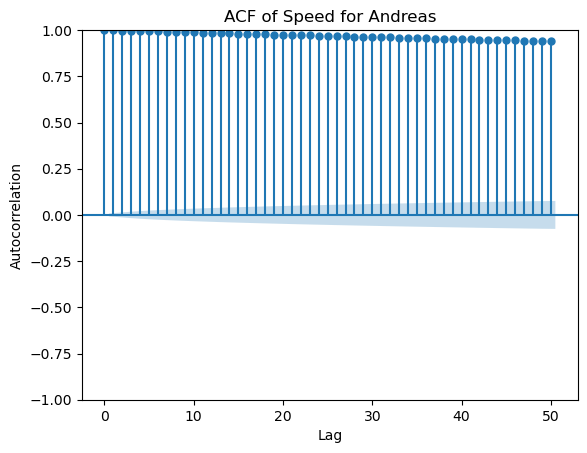

<Figure size 1200x600 with 0 Axes>

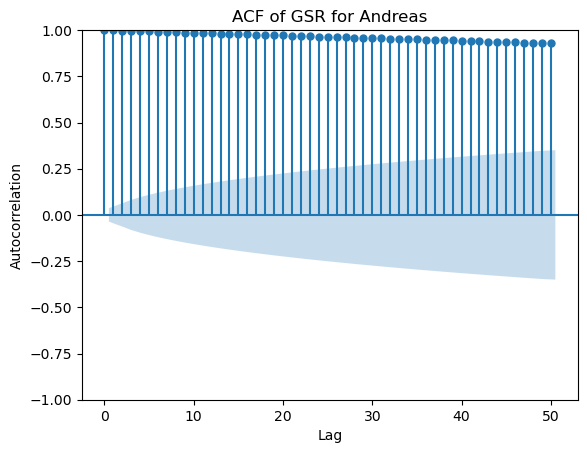

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
from statsmodels.graphics.tsaplots import plot_acf

# Assuming df_input is already defined and contains the required data
andreas_data = df_input[df_input['tester'] == 'Andreas'].iloc[0]
andreas_speed = np.concatenate([np.array(x) for x in andreas_data['Speed']])
andreas_gsr = np.concatenate([np.array(x) for x in andreas_data['GSR']])

# Create the directory if it doesn't exist
if not os.path.exists('exploratory'):
    os.makedirs('exploratory')

# Plot 1: Time Series of Speed for Andreas
plt.figure(figsize=(12, 6))
plt.plot(andreas_speed, label='Speed')
plt.title('Time Series of Speed for Andreas')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.savefig('exploratory/time_series_speed_andreas.png')


# Plot 2: Time Series of GSR for Andreas
plt.figure(figsize=(12, 6))
plt.plot(andreas_gsr, label='GSR')
plt.title('Time Series of GSR for Andreas')
plt.xlabel('Time')
plt.ylabel('GSR')
plt.legend()
plt.savefig('exploratory/time_series_gsr_andreas.png')


# Plot 3: ACF of Speed for Andreas
plt.figure(figsize=(12, 6))
plot_acf(andreas_speed, lags=50)
plt.title('ACF of Speed for Andreas')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.savefig('exploratory/acf_speed_andreas.png')


# Plot 4: ACF of GSR for Andreas
plt.figure(figsize=(12, 6))
plot_acf(andreas_gsr, lags=50)
plt.title('ACF of GSR for Andreas')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.savefig('exploratory/acf_gsr_andreas.png')



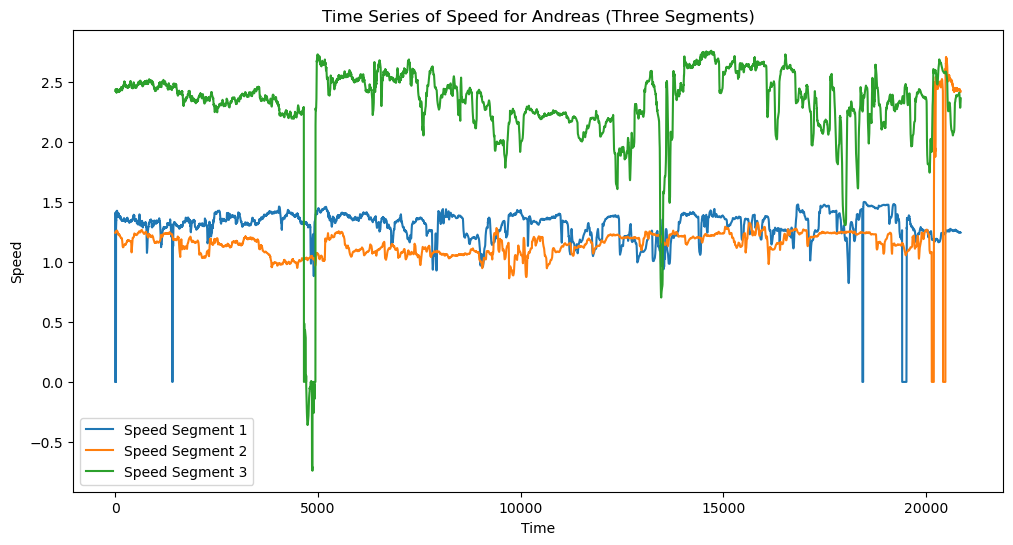

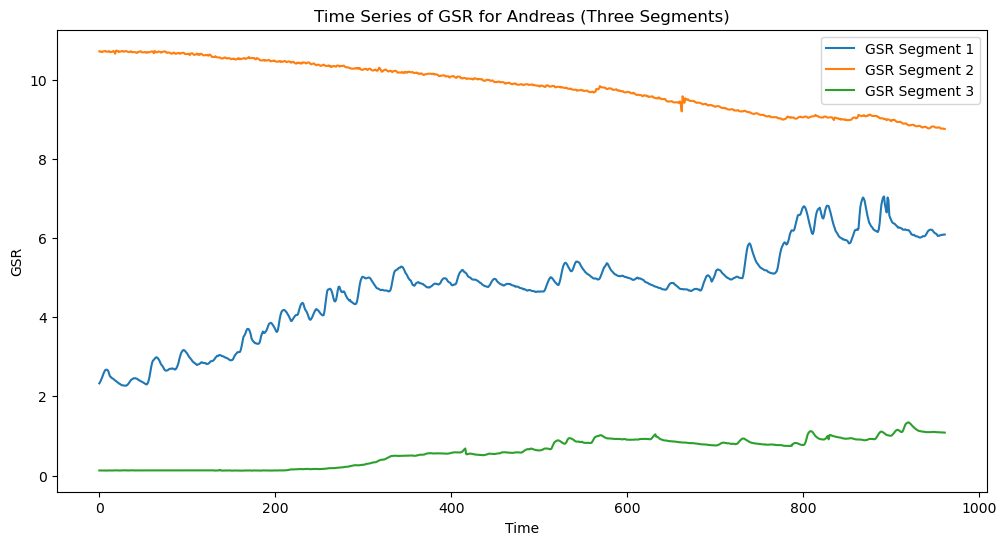

<Figure size 1200x600 with 0 Axes>

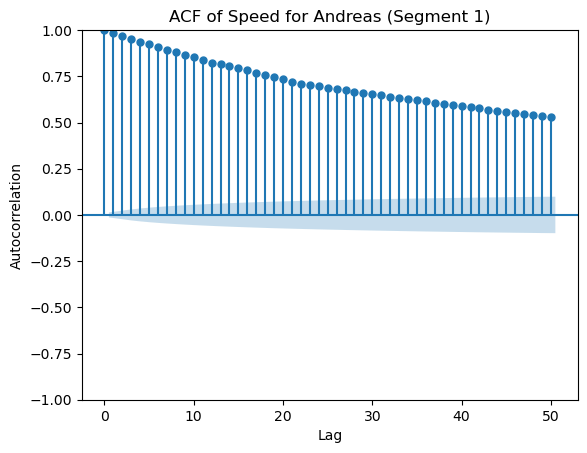

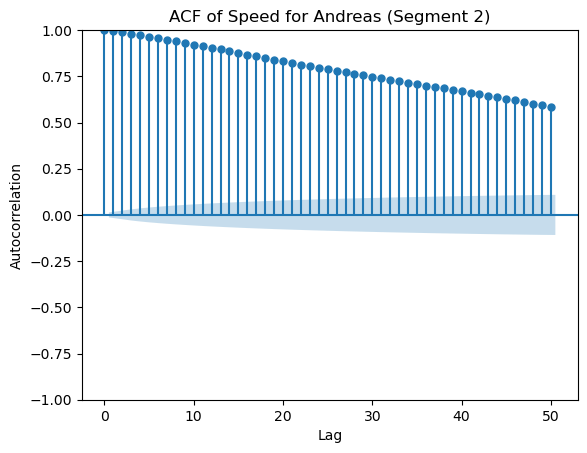

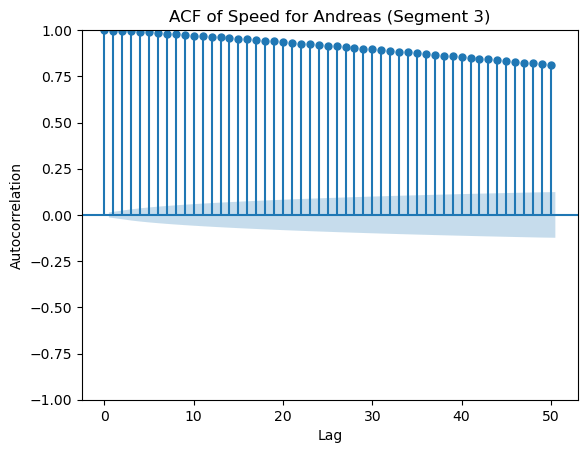

<Figure size 1200x600 with 0 Axes>

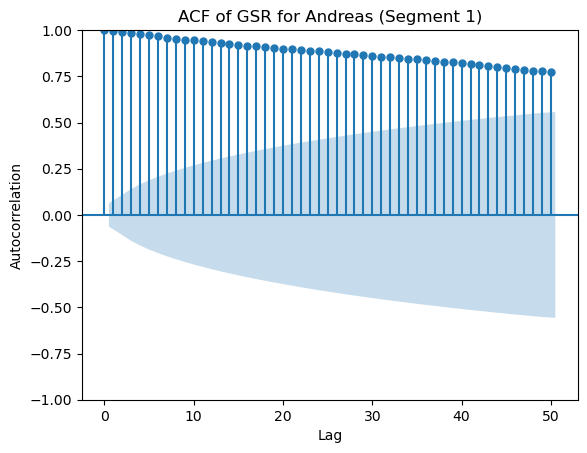

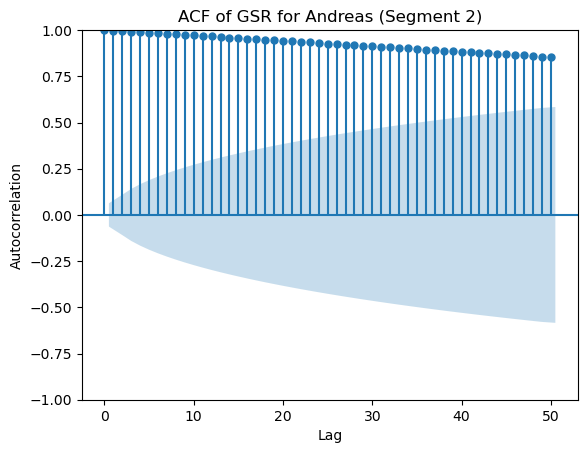

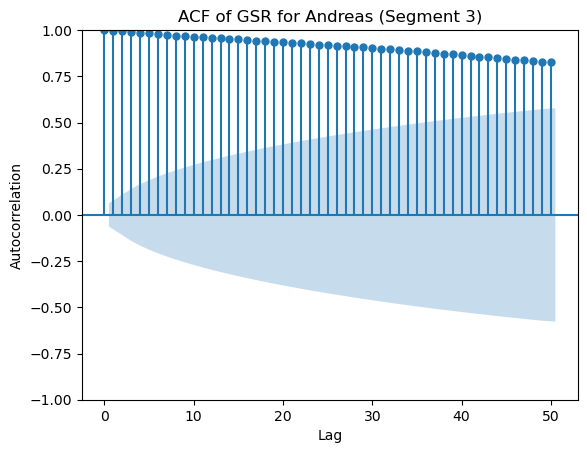

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
from statsmodels.graphics.tsaplots import plot_acf

# Assuming df_input is already defined and contains the required data
andreas_data = df_input[df_input['tester'] == 'Andreas'].iloc[0]
andreas_speed = np.concatenate([np.array(x) for x in andreas_data['Speed']])
andreas_gsr = np.concatenate([np.array(x) for x in andreas_data['GSR']])

# Create the directory if it doesn't exist
if not os.path.exists('exploratory'):
    os.makedirs('exploratory')

# Define function to split data into three segments
def split_into_segments(data):
    length = len(data) // 3
    return data[:length], data[length:2*length], data[2*length:]

# Split the data into three segments
speed_segments = split_into_segments(andreas_speed)
gsr_segments = split_into_segments(andreas_gsr)

# Plot each segment separately for Speed
plt.figure(figsize=(12, 6))
for i, segment in enumerate(speed_segments, 1):
    plt.plot(segment, label=f'Speed Segment {i}')
plt.title('Time Series of Speed for Andreas (Three Segments)')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.savefig('exploratory/time_series_speed_andreas.png')

# Plot each segment separately for GSR
plt.figure(figsize=(12, 6))
for i, segment in enumerate(gsr_segments, 1):
    plt.plot(segment, label=f'GSR Segment {i}')
plt.title('Time Series of GSR for Andreas (Three Segments)')
plt.xlabel('Time')
plt.ylabel('GSR')
plt.legend()
plt.savefig('exploratory/time_series_gsr_andreas.png')

# Plot ACF for each segment of Speed
plt.figure(figsize=(12, 6))
for i, segment in enumerate(speed_segments, 1):
    plot_acf(segment, lags=50)
    plt.title(f'ACF of Speed for Andreas (Segment {i})')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.savefig(f'exploratory/acf_speed_andreas_segment_{i}.png')

# Plot ACF for each segment of GSR
plt.figure(figsize=(12, 6))
for i, segment in enumerate(gsr_segments, 1):
    plot_acf(segment, lags=50)
    plt.title(f'ACF of GSR for Andreas (Segment {i})')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.savefig(f'exploratory/acf_gsr_andreas_segment_{i}.png')


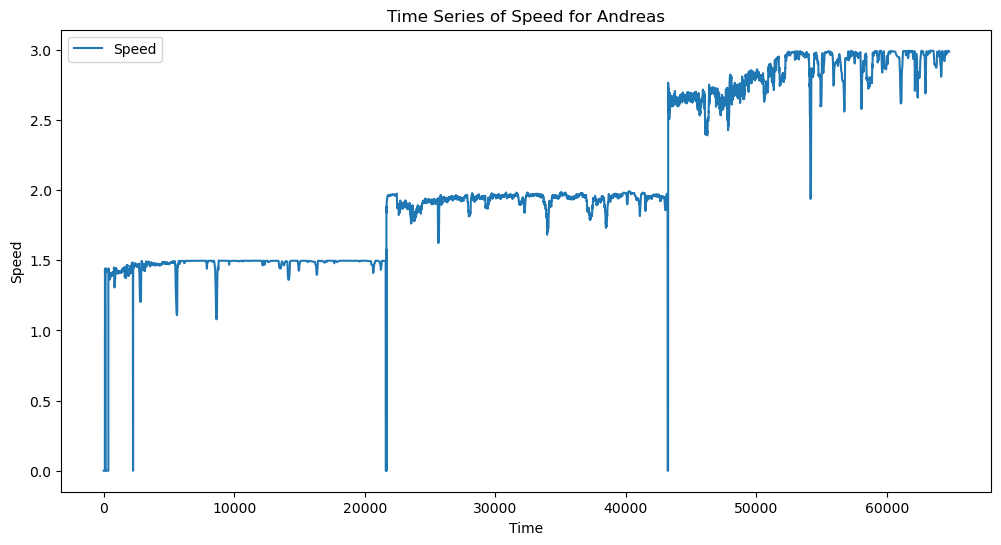

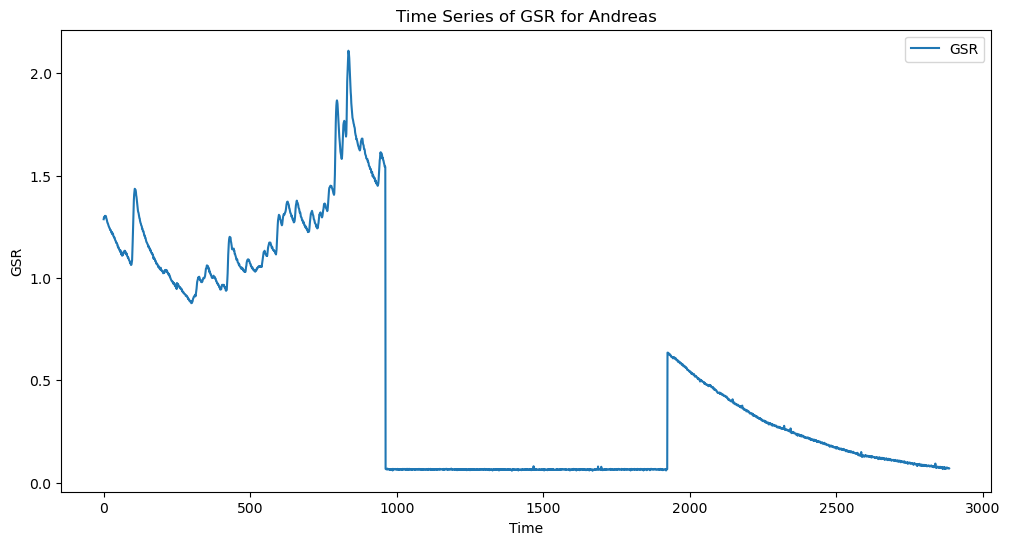

<Figure size 1200x600 with 0 Axes>

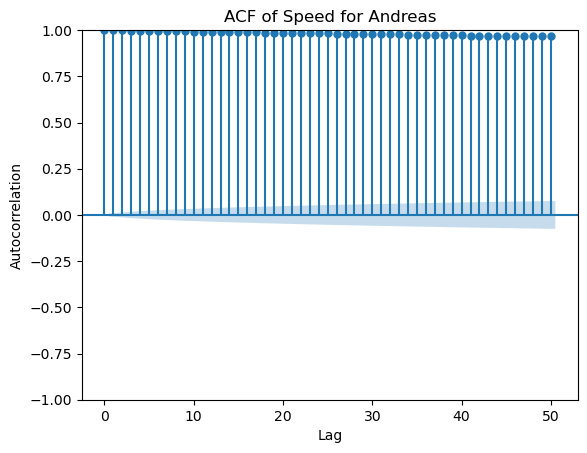

<Figure size 1200x600 with 0 Axes>

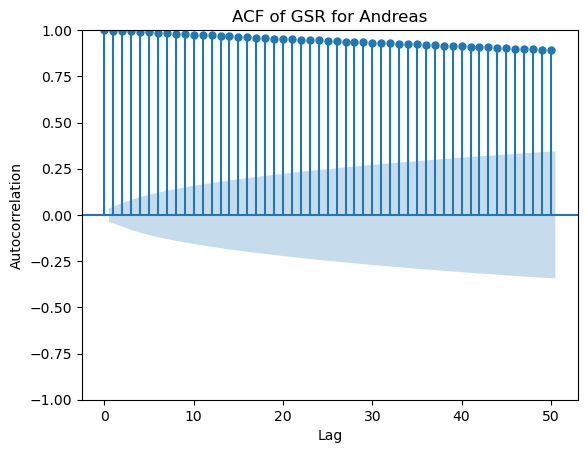

In [15]:
andreas_data = df_input[df_input['tester'] == 'Anjela'].iloc[0]
andreas_speed = np.concatenate([np.array(x) for x in andreas_data['Speed']])
andreas_gsr = np.concatenate([np.array(x) for x in andreas_data['GSR']])

plt.figure(figsize=(12, 6))
plt.plot(andreas_speed, label='Speed')
plt.title('Time Series of Speed for Andreas')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(andreas_gsr, label='GSR')
plt.title('Time Series of GSR for Andreas')
plt.xlabel('Time')
plt.ylabel('GSR')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(andreas_speed, lags=50)
plt.title('ACF of Speed for Andreas')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(andreas_gsr, lags=50)
plt.title('ACF of GSR for Andreas')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()



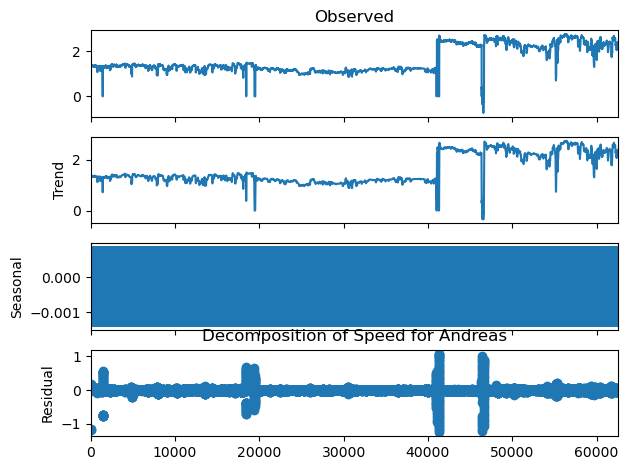

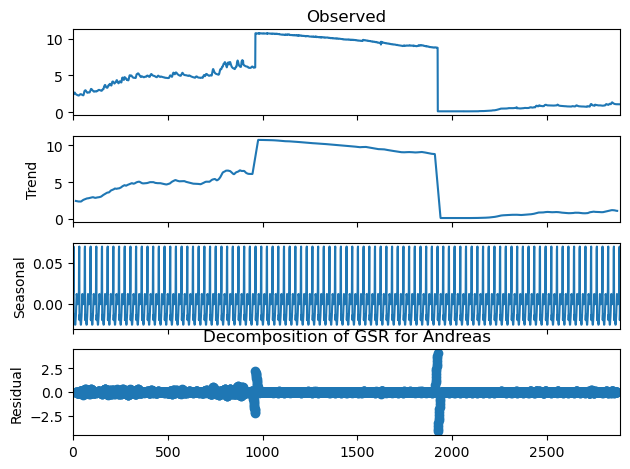

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

andreas_data = df_input[df_input['tester'] == 'Andreas'].iloc[0]
andreas_speed = np.concatenate([np.array(x) for x in andreas_data['Speed']])
andreas_gsr = np.concatenate([np.array(x) for x in andreas_data['GSR']])

result_speed = seasonal_decompose(andreas_speed, model='additive', period=30)
result_speed.plot()
plt.title('Decomposition of Speed for Andreas')
plt.show()

# 对GSR数据进行分解
result_gsr = seasonal_decompose(andreas_gsr, model='additive', period=30)
result_gsr.plot()
plt.title('Decomposition of GSR for Andreas')
plt.show()


In [ ]:
# some stationary test

In [53]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF test
adf_result = adfuller(andreas_speed)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


# ADF test
adf_result = adfuller(andreas_gsr)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')



# # KPSS检验
# kpss_result, kpss_p, _, _ = kpss(andreas_speed)
# print(f'KPSS Statistic: {kpss_result}')
# print(f'p-value: {kpss_p}')


# KPSS检验
kpss_result, kpss_p, _, _ = kpss(andreas_gsr)
print(f'KPSS Statistic: {kpss_result}')
print(f'p-value: {kpss_p}')


ADF Statistic: -4.929092270768974
p-value: 3.060122723717987e-05
ADF Statistic: -1.1777332053210763
p-value: 0.683100241516357
KPSS Statistic: 3.0447046921621532
p-value: 0.01


/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_2008/122173317.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result, kpss_p, _, _ = kpss(andreas_gsr)


### Stationarity Analysis of `andreas_speed` Time Series

**Augmented Dickey-Fuller (ADF) Test**

- **p-value:** \(3.06 \times 10^{-5}\)

The ADF test examines the null hypothesis that a unit root is present in the time series, suggesting non-stationarity.

- **Null Hypothesis (\(H_0\))**: The series has a unit root (non-stationary).
- **Alternative Hypothesis (\(H_1\))**: The series does not have a unit root (stationary).

**Conclusion:** We reject the null hypothesis, indicating that the `andreas_speed` time series is likely stationary.


### Stationarity Analysis of `andreas_GSR` Time Series

Similarly, 
**Conclusion:** We maintain the null hypothesis, indicating that the `andreas_gsr` time series is not stationary.

In [11]:
df_output = pd.DataFrame(merged_output_list,columns=['tester', 'tmp_msdv', 'peaks'])
df_output

,tester,tmp_msdv,peaks
0,Andreas,"[[0.0, 10.235038632014964, 14.073332389627016,...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [2...."
1,Anjela,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1...."
2,Anne,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4.0], [7.0], [5.0], [4.0], [6.0], [4.0], [6...."
3,Aron,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0], [4.0], [5.0], [3.0], [5.0], [6.0], [3...."
4,BingHan,"[[0.0, 3.154252773752122, 3.7037348249875524, ...","[[2.0], [2.0], [1.0], [0.0], [2.0], [1.0], [1...."
5,Bowen,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0], [5.0], [4.0], [4.0], [4.0], [6.0], [5...."
6,Chenyang,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
7,Cunbo,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4.0], [5.0], [5.0], [5.0], [6.0], [5.0], [6...."
8,Danfo,"[[0.0, 6.530872954118741, 7.6432728994553365, ...","[[0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0...."
9,Emilio,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.0], [4.0], [7.0], [6.0], [7.0], [6.0], [6...."
